<a href="https://colab.research.google.com/github/Jerez-lab/ML-course/blob/main/6_lab/lab6_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание 1
Реализовать вычисление энтропии и посчитать её значение для:

* (0.2, 0.2, 0.2, 0.2, 0.2)
* (0.5, 0.5)
* (0.9, 0.05, 0.05, 0)
* (0, 0, 0, 0, 1, 0)

Объяснить полученные результаты.

In [ ]:
import numpy as np
import math

In [ ]:
p1 = np.array((0.2, 0.2, 0.2, 0.2, 0.2))
p2 = np.array((0.5, 0.5))
p3 = np.array((0.9, 0.05, 0.05, 0))
p4 = np.array((0, 0, 0, 0, 1, 0))

In [ ]:
def calc_entropy(p: np.array):
    return -np.nansum(p * np.log2(p))

In [ ]:
print(f"""Entropy 1: {calc_entropy(p1)}""")
print(f"""Entropy 2: {calc_entropy(p2)}""")
print(f"""Entropy 3: {calc_entropy(p3)}""")
print(f"""Entropy 4: {calc_entropy(p4)}""")

Entropy 1: 2.321928094887362
Entropy 2: 1.0
Entropy 3: 0.5689955935892812
Entropy 4: -0.0


<ipython-input-17-9e584a70e92a>:2: RuntimeWarning: divide by zero encountered in log2
  return -np.nansum(p * np.log2(p))
<ipython-input-17-9e584a70e92a>:2: RuntimeWarning: invalid value encountered in multiply
  return -np.nansum(p * np.log2(p))


В первых двух случаях энтропия наибольшая: все вероятности равны и невозможно сделать предположение о полученном варианте.

В третьем случае наибольшая вероятность для первого варианта, и она сильно больше остальных, поэтому энтропия уменьшается.

В четвертом случае имеется лишь один вариант с ненулевой вероятностью, следовательно никакой неопределенности нет: энтропия равна нулю.

## Задание 2
* Напишите класс дерева, который реализует метод train, получающий на вход матрицу данных (𝑥) и целевые переменные (𝑦), на выходе функция возвращает дерево в виде словаря
* в каждом случае записывается номер признака (𝑖), порог разбиения(𝑡), значение в листовой вершине слева (𝑦𝑙) и значение в листовой вершине справа (𝑦𝑟).
* Вместо значения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее

Необходимо учесть:

* Возможность строить дерево строго определенной глубины и возможность указать максимальное количество объектов в листовой вершине.
* Пороги разбиения должны лежать строго по середине между ближайшими обектами.
* Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
* Количество различных классов объектов в целевой переменной может быть больше двух.


* Постройте решающее дерево с глубиной 1, 2 и 3.
* Также постройте дерево максимальной глубины
* Визуализируйте получившиеся результаты классификатора на плоскости (код есть в предыдущих лабах)

## Структура данных
Мы используем бинарное дерево для присвоения информации узлам дерева решений. В частности, экземпляры, связанные с этим узлом (data_indices), и тест, который используется для дальнейшего разбиения этого узла, в случае нелистовых узлов (split_feature, split_value).


Здесь мы предполагаем, что каждый тест включает один признак, и все признаки являются вещественно-значимыми.

In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices #сохраняет индексы данных, которые находятся в области, определенной этим узлом
        self.left = None #сохраняет левый дочерний элемент узла 
        self.right = None #сохраняет правый дочерний узел
        self.split_feature = None #функция для разделения в этом узле
        self.split_value = None #значение функции для разделения в этом узле
        if parent:
            self.depth = parent.depth + 1 #получение глубины узла путем прибавления единицы к глубине родителя 
            self.num_classes = parent.num_classes #копирует num_classes из родительского узла 
            self.data = parent.data #копирует данные из родителя
            self.labels = parent.labels #копирует метки из родительского файла
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) 
            #это подсчет частоты различных меток в области, определенной этим узлом
            self.class_prob = class_prob / np.sum(class_prob) #сохраняет вероятность класса для узла
            #заметим, что мы будем использовать вероятности классов листовых узлов
            #для составления прогнозов после построения дерева

In [ ]:
def greedy_test(node, cost_fn):
    #инициализируем значения лучших параметров
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #сортирует признаки для получения кандидатов на тестовое значение,
    #взяв среднее значение последовательных отсортированных значений признаков 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #сохраням данные, соответствующие f-й характеристике
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Разделим индексы, используя тестовое значение f-го признака
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #не может быть разбиения, в котором дочерний элемент имеет нулевой элемент.
            #если это верно для всех тестовых функций и их тестовых значений, 
            #то функция возвращает наилучшую стоимость как бесконечность
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #вычисляем левую и правую стоимость на основе текущего разбиения                                                              
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #получаем комбинированную стоимость, используя взвешенную сумму левой и правой стоимости
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #обновляем только при появлении более низкой стоимости
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

Ниже мы реализуем функции затрат, соответствующие скорости ошибочной классификации и энтропии.

In [ ]:
#Вычисляеьт стоимость ошибочной классификации путем вычитания максимальной вероятности любого класса
def cost_misclassification(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#Вычисляет энтропию меток путем вычисления вероятностей классов
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              
    #Эти шаги удаляют 0 вероятностей для устранения числовых проблем при вычислении журнала
    return -np.sum(class_probs * np.log(class_probs)) 

def cost_misclassification(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

In [ ]:
class Tree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1):
        self.max_depth = max_depth      #максимальная глубина для расторжения 
        self.root = None                #хранит корень дерева решений
        self.cost_fn = cost_fn          #хранит cost_fn дерева решений 
        self.num_classes = num_classes  #хранит общее количество классов
        self.min_leaf_instances = min_leaf_instances  #минимальное количество экземпляров в листе для прекращения работы
        
    def fit(self, data, labels):
        pass
    
    def predict(self, data_test):
        pass

In [ ]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #ниже приведена инициализация корня дерева решений
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #для рекурсивного построения остальной части дерева
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #Это дает условие для завершения рекурсии, приводящей к листовому узлу
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #выбирает лучший тест, минимизируя стоимость
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #если возвращаемая стоимость равна бесконечности, это означает, что разделить узел невозможно и, следовательно, return функции
    if np.isinf(cost):
        return
    test = node.data[node.data_indices,split_feature] <= split_value
    #хранит признак разделения и значение узла
    node.split_feature = split_feature
    node.split_value = split_value
    #определяет новые узлы, которые будут левым и правым дочерними узлами текущего узла
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #рекурсивный вызов функции _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    node.left = left
    node.right = right

Tree.fit = fit
Tree._fit_tree = _fit_tree

In [ ]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #Цикл по глубине дерева ищет область, в которую попадает текущий образец данных
        #на основе разделенного признака и значения
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #цикл завершается при достижении листа дерева,
        #и для прогнозирования берется вероятность класса этого узла
        class_probs[n,:] = node.class_prob
    return class_probs

Tree.predict = predict

In [ ]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np

x, y = make_moons(n_samples=100, noise=0.1)
(num_instances, num_features), num_classes = x.shape, np.max(y)+1
inds = np.random.permutation(num_instances)
x_train, y_train = x[inds[:90]], y[inds[:90]]
x_test, y_test = x[inds[90:]], y[inds[90:]]

accuracy is 100.0.


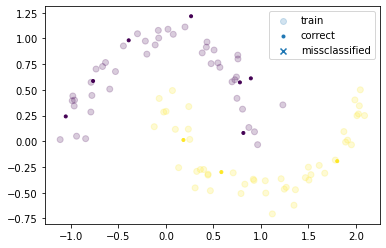

In [ ]:
tree = Tree(max_depth=20)
probs_test = tree.fit(x, y).predict(x_test)
y_pred = np.argmax(probs_test,1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')


#визуализация
correct = y_test == y_pred
incorrect = np.logical_not(correct)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='missclassified')
plt.legend()
plt.show()

In [ ]:
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 100)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 100)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = Tree(max_depth=200)
#y_train_prob = np.zeros((y_train.shape[0], num_classes))
#y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
#y_prob_all = model.fit(x_train, y_train).predict(x_all)


#plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
#plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
#plt.show()

## Задание 3
Выполните задание 2 с помощью sklearn

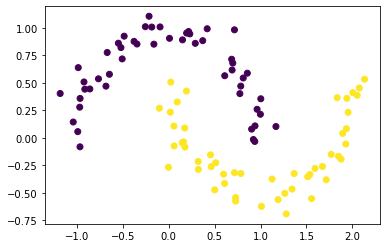

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs, make_moons

x, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(x[:,0], x[:,1], c = y);

In [ ]:
def draw_class_border(clf, x, y, h=.03, cmap=plt.cm.coolwarm):
    x_min, x_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
    y_min, y_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                           np.arange(y_min, y_max, h))

    Z = clf.predict(np.vstack((xx.ravel(), yy.ravel())).transpose())
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,8))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=.5)
    plt.scatter(x[:,0], x[:,1], s=200, c = y, cmap=cmap)
    plt.title(f"max_depth = {clf.max_depth}")
    plt.show()

In [ ]:
def accuracy(pred, real):
    counter = 0;
    for i in range(pred.shape[0]):
        if pred[i] == real[i]:
            counter += 1
    return counter / pred.shape[0]

In [ ]:
X_train = x[:70]
Y_train = y[:70]
X_test = x[70:]
Y_test = y[70:]

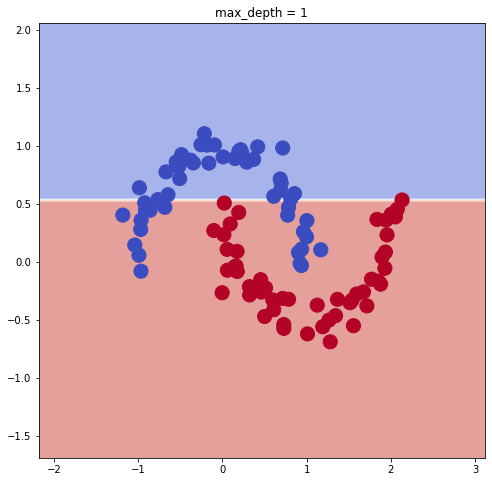

Прогнозируемые метки с 1 глубиной: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0]
Показатель точности с 1 глубиной составляет 0.7666666666666667


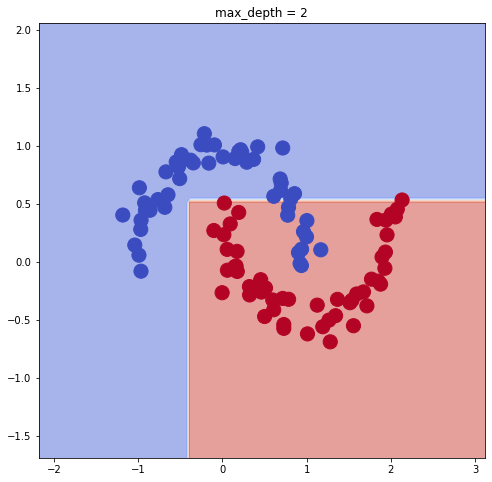

Прогнозируемые метки с 2 глубиной: [1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0]
Показатель точности с 2 глубиной составляет 0.9


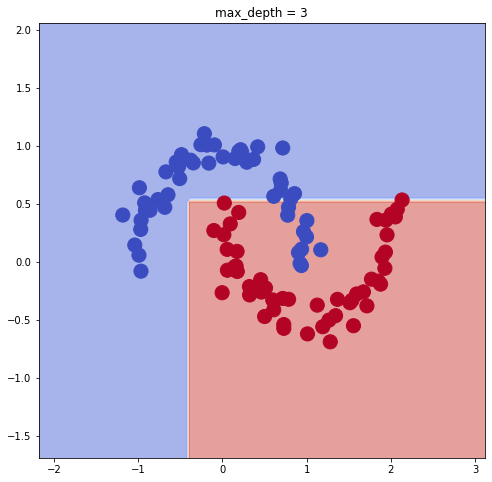

Прогнозируемые метки с 3 глубиной: [1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0]
Показатель точности с 3 глубиной составляет 0.9


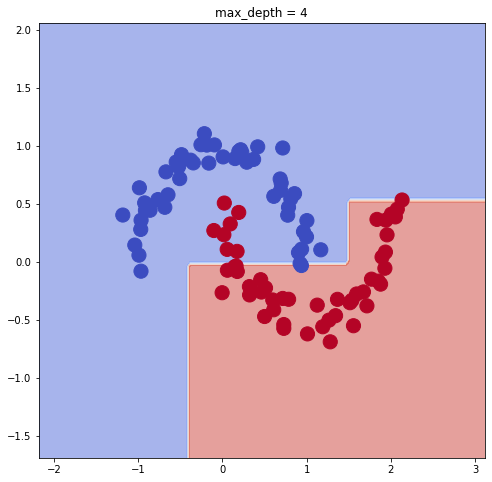

Прогнозируемые метки с 4 глубиной: [0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 0]
Показатель точности с 4 глубиной составляет 0.8333333333333334


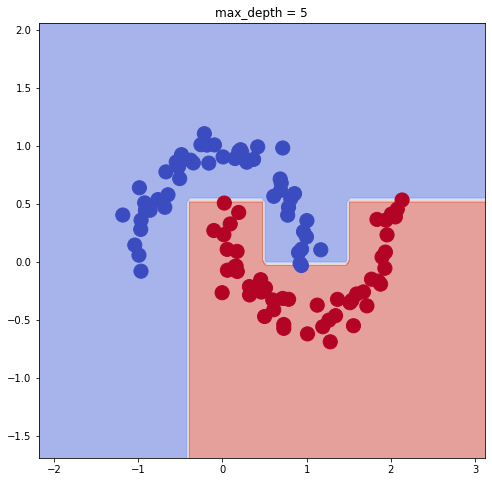

Прогнозируемые метки с 5 глубиной: [0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0]
Показатель точности с 5 глубиной составляет 0.9666666666666667


In [ ]:
depths = [1, 2, 3, 4,5]

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, Y_train)
    draw_class_border(dt, x, y, h=.05)

    Y_pred = dt.predict(X_test)
    print(f"Прогнозируемые метки с {depth} глубиной: {Y_pred}")
    print(f"Показатель точности с {depth} глубиной составляет {accuracy(Y_pred, Y_test)}")